# 🏁 Wrap-up quiz

**This quiz requires some programming to be answered.**

Open the dataset `bike_rides.csv` with the following commands:

In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


A detailed description of this dataset is given in the appendix. As a reminder,
the problem we are trying to solve with this dataset is to use measurements
from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a
cyclist power. Power can indeed be recorded via a cycling power meter device,
but this device is rather expensive.

Instead of using blindly machine learning, we will first introduce some flavor of
classic mechanics: the Newton's second law.

$P_{meca} = (\frac{1}{2} \rho . SC_x . V_{a}^{2} + C_r . mg . \cos \alpha + mg . \sin \alpha + ma) V_d$

where $\rho$ is the air density in kg.m$^{-3}$, $S$ is frontal surface of the
cyclist in m$^{2}$, $C_x$ is the drag coefficient, $V_a$ is the air speed in
m.s$^{-1}$, $C_r$ is the rolling coefficient, $m$ is the mass of the rider and
bicycle in kg, $g$ is the standard acceleration due to gravity which is equal
to 9.81 m.s$^{-2}$, $\alpha$ is the slope in radian, $V_d$ is the rider speed
in m.s$^{-1}$, and $a$ is the rider acceleration in m.s$^{-2}$.

This equation might look a bit complex at first but we can explain with words
what the different terms within the parenthesis are:

- the first term is the power that a cyclist is required to produce to fight wind
- the second term is the power that a cyclist is required to produce to fight
  the rolling resistance created by the tires on the floor
- the third term is the power that a cyclist is required to produce to go up a hill if the
  slope is positive. If the slope is negative the cyclist does not need to
  produce any power to go forward
- the fourth and last term is the power that a cyclist requires to change his
  speed (i.e. acceleration).

We can simplify the model above by using the data that we have at hand. It
would look like the following.

$P_{meca} = \beta_{1} V_{d}^{3} + \beta_{2} V_{d} + \beta_{3} \sin(\alpha) V_{d} + \beta_{4} a V_{d}$

This model is closer to what we saw previously: it is a linear model trained
on a non-linear feature transformation. We will build, train and evaluate
such a model as part of this exercise. Thus, you need to:

- create a new data matrix containing the cube of the speed, the speed, the
  speed multiplied by the sine of the angle of the slope, and the speed
  multiplied by the acceleration. To compute the angle of the slope, you need
  to take the arc tangent of the slope (`alpha = np.arctan(slope)`). In
  addition, we can limit ourself to positive acceleration only by clipping to 0
  the negative acceleration values (they would correspond to some power created
  by the braking that we are not modeling here).
- using the new data matrix, create a linear predictive model based on a
  [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  and a
  [`sklearn.linear_model.RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html);
- use a
  [`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
  cross-validation strategy with only 4 splits (`n_splits=4`) to evaluate the
  statistical performance of the model. Use the mean absolute error (MAE) as a
  statistical performance metric. Also, pass the parameter
  `return_estimator=True` and `return_train_score=True` to answer the
  subsequent questions. Be aware that the `ShuffleSplit` strategy is a naive
  strategy and we will investigate the consequence of making this choice in the
  subsequent questions.

In [7]:
import numpy as np
data['cube_speed']=data['speed']**3
data['speed_sin_alpha']=data['speed']*np.sin(np.arctan(data['slope']))
data['fixed_acc']=np.maximum(0,data['acceleration'])*data['speed']

sub_data=data[['cube_speed', 'speed', 'speed_sin_alpha', 'fixed_acc']]

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

pipeline = make_pipeline(StandardScaler(), RidgeCV())

In [12]:
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=4)

cv_result = cross_validate(pipeline, sub_data, target, cv=cv, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')
cv_result

{'fit_time': array([0.0150106 , 0.02893567, 0.01329589, 0.01390219]),
 'score_time': array([0.00279474, 0.00901055, 0.00195122, 0.00201058]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])],
 'test_score': array([-72.09835051, -71.16135251, -72.60977333, -72.9900542 ]),
 'train_score': array([-72.53710934, -72.61620569, -72.45470581, -72.41001551])}

In [11]:
sub_data['speed_sin_alpha'].mean()

-0.002709709612566326

# Question 1
What is the mean value of the column containing the information of
$\sin(\alpha) V_{d}$?

- a) about -3
- b) about -0.3
- c) about -0.03
- d) about -0.003

```

In [14]:
-cv_result['test_score'].mean()

72.2148826376446

# Question 2
On average, the Mean Absolute Error on the test sets obtained through
cross-validation is closest to:

- a) 20 Watts
- b) 50 Watts
- c) 70 Watts
- d) 90 Watts

_Select a single answer_

Hint: pass `scoring="neg_mean_absolute_error"` to the `cross_validate`
function to compute the (negative of) the requested metric.
Hint: it is possible to replace the negative acceleration values by 0 using
`data["acceleration"].clip(lower=0)`
```

In [21]:
for est in cv_result['estimator']:
    print(est['ridgecv'].coef_)

[ 5.03703196 33.40025539 80.30378346 11.52956138]
[ 4.93114687 33.33073823 79.82982746 11.22342699]
[ 6.23821071 32.73978669 81.00726969 11.25124437]
[ 5.81213121 32.75361102 80.8797795  11.05921848]


# Question 3
Given the model
$P_{meca} = \beta_{1} V_{d}^{3} + \beta_{2} V_{d} + \beta_{3} \sin(\alpha) V_{d} + \beta_{4} a V_{d}$
that you created, inspect the weights of the linear models fitted during
cross-validation and select the correct statements:

- a) $\beta_{1} < \beta_{2} < \beta_{3}$
- b) $\beta_{3} < \beta_{1} < \beta_{2}$
- c) $\beta_{2} < \beta_{3} < \beta_{1}$
- d) $\beta_{1} < 0$
- e) $\beta_{2} < 0$
- f) $\beta_{3} < 0$
- g) $\beta_{4} < 0$
- h) All $\beta$s are $> 0$

_Select several answers_
```

+++

Now, we will create a predictive model that uses all available sensor
measurements such as cadence (the speed at which a cyclist turns pedals
measured in rotation per minute) and heart-rate (the number of beat per minute
of the heart of the cyclist while exercising). Also, we will use a non-linear
regressor, a
[`sklearn.ensemble.HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).
Fix the number of maximum iterations to 1000 (`max_iter=1_000`) and activate
the early stopping (`early_stopping=True`). Repeat the previous evaluation
using this regressor.

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

pipelineHGB = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(max_iter=1000, early_stopping=True))
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=4)

cv_result = cross_validate(pipelineHGB, data, target, cv=cv, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')
cv_result


{'fit_time': array([0.71255255, 0.46640062, 0.67974997, 0.79434657]),
 'score_time': array([0.00897622, 0.0067668 , 0.00911832, 0.00934291]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',
                   HistGradientBoostingRegressor(early_stopping=True,
                                                 max_iter=1000))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',
                   HistGradientBoostingRegressor(early_stopping=True,
                                                 max_iter=1000))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',
                   HistGradientBoostingRegressor(early_stopping=True,
                                                 max_iter=1000))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',

# Question 4
On average, the Mean Absolute Error on the test sets obtained through
cross-validation is closest to:

- a) 20 Watts
- b) 40 Watts
- c) 60 Watts
- d) 80 Watts

_Select a single answer_
```

# Question 5
Comparing both the linear model and the histogram gradient boosting model and
taking into consideration the train and test MAE obtained via cross-validation,
select the correct statements:

- a) the statistical performance of the histogram gradient-boosting model is
  limited by its underfitting
- b) the statistical performance of the histogram gradient-boosting model is
  limited by its overfitting
- c) the statistical performance of the linear model is limited by its
  underfitting
- d) the statistical performance of the linear model is limited by its
  overfitting

_Select several answers_

Hint: look at the values of the `train_score` and the `test_score` collected
in the dictionaries returned by the `cross_validate` function.
```

+++

In the previous cross-validation, we made the choice of using a `ShuffleSplit`
cross-validation strategy. It means that randomly selected samples were
selected as a testing test ignoring any time dependency between the lines of
the dataframe.

We would like to have a cross-validation strategy that evaluates the capacity
of our model to predict on a completely new bike ride: the samples in the
validation set should only come from rides not present in the training set.

<AxesSubplot:>

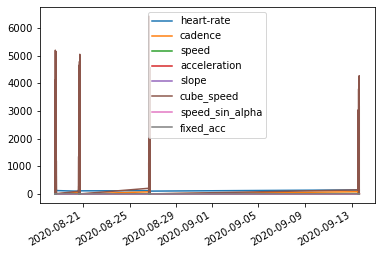

In [25]:
data.plot()

# Question 6
How many bike rides are stored in the dataframe `data`? Do not hesitate to
look at the hints.

- a) 2
- b) 3
- c) 4
- d) 5

_Select a single answer_

Hint: You can check the unique day in the `DatetimeIndex` (the index of the
dataframe `data`). Indeed, we assume that on a given day the rider went cycling
at most once per day.
Hint: You can access to the date and time of a `DatetimeIndex` using
`df.index.date` and `df.index.time`, respectively.
```

+++

Instead of using the naive `ShuffleSplit` strategy, we will use a strategy that
takes into account the group defined by each individual date. It corresponds to
a bike ride. We would like to have a cross-validation strategy that evaluates
the capacity of our model to predict on a completely new bike ride: the samples
in the validation set should only come from rides not present in the training
set. Therefore, we can use a `LeaveOneGroupOut` strategy: at each iteration of
the cross-validation, we will keep a bike ride for the evaluation and use all
other bike rides to train our model.

Thus, you concretely need to:

- create a variable called `group` that is a 1D numpy array containing the
  index of each ride present in the dataframe. Therefore, the length of `group`
  will be equal to the number of samples in `data`. If we had 2 bike
  rides, we would expect the indices 0 and 1 in `group` to differentiate the
  bike ride. You can use
  [`pd.factorize`](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html)
  to encode any Python types into integer indices.
- create a cross-validation object named `cv` using the
  [`sklearn.model_selection.LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut)
  strategy.
- evaluate both the linear and histogram gradient boosting models with this
  strategy.

In [48]:
data['group']=data.index
data['group']=data['group'].dt.day
codes, uniques = pd.factorize(data['group'])
data['group']=codes
data

from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()

cv_result_HGB = cross_validate(pipelineHGB, data, target, cv=cv, groups=codes, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')
print(cv_result_HGB)

cv_result_LR = cross_validate(pipeline, sub_data, target, cv=cv, groups=codes, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')
print(cv_result_LR)

{'fit_time': array([0.55586624, 0.7093668 , 0.85231781, 0.84894657]), 'score_time': array([0.01506519, 0.01771355, 0.02239823, 0.01814365]), 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               max_iter=1000))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               max_iter=1000))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               max_iter=1000))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingregressor',
                 HistGradie

# Question 7
Using the previous evaluations (with both `ShuffleSplit` and
`LeaveOneGroupOut`) and looking at the train and test errors for both models,
select the correct statements:

- a) the statistical performance of the gradient-boosting model is
  limited by its underfitting
- b) the statistical performance of the gradient-boosting model is
  limited by its overfitting
- c) the statistical performance of the linear model is limited by its
  underfitting
- d) the statistical performance of the linear model is limited by its
  overfitting

_Select several answers_
```

In [53]:
print(f'test score for linear model : {-cv_result_LR["test_score"].mean():0.02f} +/- {-cv_result_LR["test_score"].std():0.02f}')
print(f'test score for HGB model : {-cv_result_HGB["test_score"].mean():0.02f} +/- {-cv_result_HGB["test_score"].std():0.02f}')


test score for linear model : 73.01 +/- -5.78
test score for HGB model : 51.24 +/- -3.10


# Question 8
Using the previous evaluations (with both `ShuffleSplit` and
`LeaveOneGroupOut`) and looking at the train and test errors for both models,
select the correct statements:

- a) `ShuffleSplit` is giving over-optimistic results for the linear model
- b) `LeaveOneGroupOut` is giving over-optimistic results for the linear model
- c) both cross-validation strategies are equivalent for the linear model
- d) `ShuffleSplit` is giving over-optimistic results for the gradient-boosting model
- e) `LeaveOneGroupOut` is giving over-optimistic results for the gradient-boosting model
- f) both cross-validation strategies are equivalent for the gradient-boosting model

_Select several answer_
```

# Question 9
Compare more precisely the errors estimated through cross-validation and select
the correct statement:

- a) in general, the standard deviation of the train and test errors increased
  using the `LeaveOneGroupOut` cross-validation
- b) in general, the standard deviation of the train and test errors decreased
  using the `LeaveOneGroupOut` cross-validation

_Select a single answer_
```

+++

Now, we will go in details by picking a single ride for the testing and analyse
the predictions of the models for this test ride. To do so, we can reuse the
`LeaveOneGroupOut` cross-validation object in the following manner:

In [56]:
cv = LeaveOneGroupOut()
groups=codes
data_linear_model=sub_data.copy()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

Now, fit both the linear model and the histogram gradient boosting regressor
models on the training data and collect the predictions on the testing data.
Make a scatter plot where on the x-axis, you will plot the measured powers
(true target) and on the y-axis, you will plot the predicted powers
(predicted target). Do two separated plots for each model.

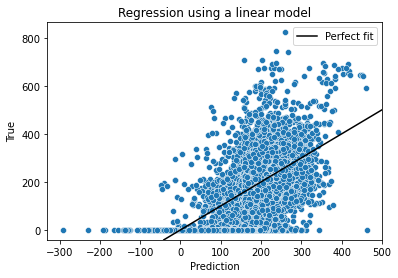

In [65]:
pipeline.fit(data_linear_model_train, target_train)
linear_pred = pipeline.predict(data_linear_model_test)

import matplotlib.pyplot as plt
import seaborn as sns

linear_df = pd.DataFrame( { 'Prediction':pd.Series(linear_pred), 'True':pd.Series(target_test.to_numpy())} )
plt.axline((0, 0), slope=1, label="Perfect fit", color='black')

sns.scatterplot(data=linear_df, x='Prediction', y='True')
_ = plt.title("Regression using a linear model")

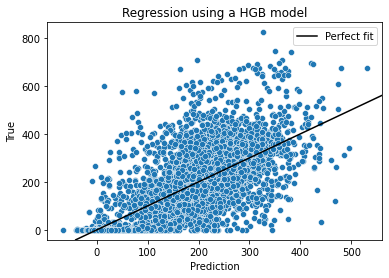

In [67]:
pipelineHGB.fit(data_train, target_train)
HGB_pred = pipelineHGB.predict(data_test)

import matplotlib.pyplot as plt
import seaborn as sns

HGB_df = pd.DataFrame( { 'Prediction':pd.Series(HGB_pred), 'True':pd.Series(target_test.to_numpy())} )
plt.axline((0, 0), slope=1, label="Perfect fit", color='black')

sns.scatterplot(data=HGB_df, x='Prediction', y='True')
_ = plt.title("Regression using a HGB model")

# Question 10
By analysing the plots, select the correct statements:

- a) the linear regressor tends to under-predict samples with high power
- b) the linear regressor tends to over-predict samples with high power
- c) the linear regressor makes catastrophic predictions for samples with low
  power
- d) the histogram gradient boosting regressor tends to under-predict samples
  with high power
- e) the histogram gradient boosting regressor tends to over-predict samples
  with high power
- f) the histogram gradient boosting makes catastrophic predictions for samples
  with low power

_Select several answers_
```

+++

Now select a portion of the testing data using the following code:

In [68]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

It allows to select data from 5.00 pm until 5.05 pm. Used the previous fitted
models (linear and gradient-boosting regressor) to predict on this portion
of the test data. Draw on the same plot the true targets and the predictions
of each model.

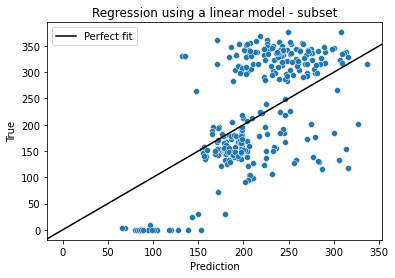

In [69]:
linear_pred = pipeline.predict(data_test_linear_model_subset)
HGB_pred = pipelineHGB.predict(data_test_subset)

linear_df = pd.DataFrame( { 'Prediction':pd.Series(linear_pred), 'True':pd.Series(target_test_subset.to_numpy())} )
plt.axline((0, 0), slope=1, label="Perfect fit", color='black')

sns.scatterplot(data=linear_df, x='Prediction', y='True')
_ = plt.title("Regression using a linear model - subset")

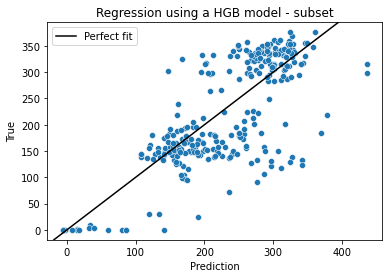

In [70]:
HGB_df = pd.DataFrame( { 'Prediction':pd.Series(HGB_pred), 'True':pd.Series(target_test_subset.to_numpy())} )
plt.axline((0, 0), slope=1, label="Perfect fit", color='black')

sns.scatterplot(data=HGB_df, x='Prediction', y='True')
_ = plt.title("Regression using a HGB model - subset")

# Question 11
By using the previous plot, select the correct statements:

- a) the linear model is more accurate than the histogram gradient boosting
  regressor
- b) the histogram gradient boosting regressor is more accurate than the linear
  model
- c) the linear model predicts smoother outputs than the histogram gradient
  boosting regressor
- d) the histogram gradient boosting regressor predicts smoother outputs
  than the linear model

_Select several answers_
```

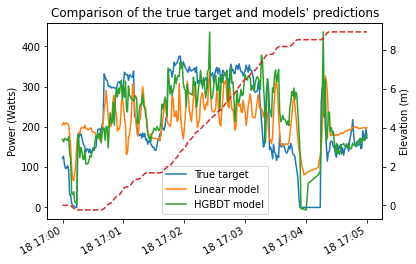

In [73]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")
linear_model = pipeline
hgbdt = pipelineHGB
data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target")
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")